# Aim: 

Predict the TESLA stock price using a forecasting ARIMA model

Source: 

- https://github.com/advaitsave/Introduction-to-Time-Series-forecasting-Python/blob/master/Time%20Series%20in%20Python.ipynb
- https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python/data
- https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70

In [229]:
import pandas as pd
import numpy as np

df=pd.read_csv("https://raw.githubusercontent.com/aastha12/Machine-Learning/master/Time%20Series/ARIMA/TSLA.csv")

In [230]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


Our target variable will be the <b>Close</b> value.

In [231]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,64.594124,65.883341,63.272302,64.642060,64.642060,3.979297e+07
std,33.400757,34.457933,32.308613,33.518742,33.518742,2.928970e+07
min,28.464001,30.993999,28.209999,28.733999,28.733999,3.540000e+06
25%,45.861999,46.425002,45.063001,45.887001,45.887001,2.158075e+07
50%,56.765999,57.888000,55.776001,56.945999,56.945999,3.081300e+07
75%,67.962001,69.039002,66.736000,67.790001,67.790001,4.658400e+07
max,281.002014,285.899994,270.256012,278.855988,278.855988,3.046940e+08


In [232]:
df.shape

(1259, 7)

In [233]:
df['Date']=pd.to_datetime(df['Date'])

In [234]:
df.sort_values(by='Date',inplace=True)

## Data visualization - Line plot

In [235]:
import plotly.express as px

fig=px.line(df,x='Date',y="Close")
fig.show()

## Data visualization - Histogram

In [236]:
fig=px.histogram(df,x="Close")
fig.show()

## Data visualization - Box Plot

In [237]:
fig=px.box(df,x=df["Date"].dt.year,y="Close")
fig.show()

- Tail heavy distribution from histogram and seasonal patterns from line plot
- Median values across years confirms an upwards trend
- Sudden increase in the spread, or middle 50% of the data (boxes) in 2020

### Decomposing using statsmodel

- We can use statsmodels to perform a decomposition of this time series.
- The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns.
- With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

In [238]:
df=df[['Date','Close']]

In [239]:
df.set_index("Date",inplace=True)

In [240]:
df = df.asfreq('d') #you have to set frequency as daily,weekly,etc. for seasonal_decompose to work
df['Close'].fillna(0,inplace=True)

In [241]:
df.isnull().sum()

Close    0
dtype: int64

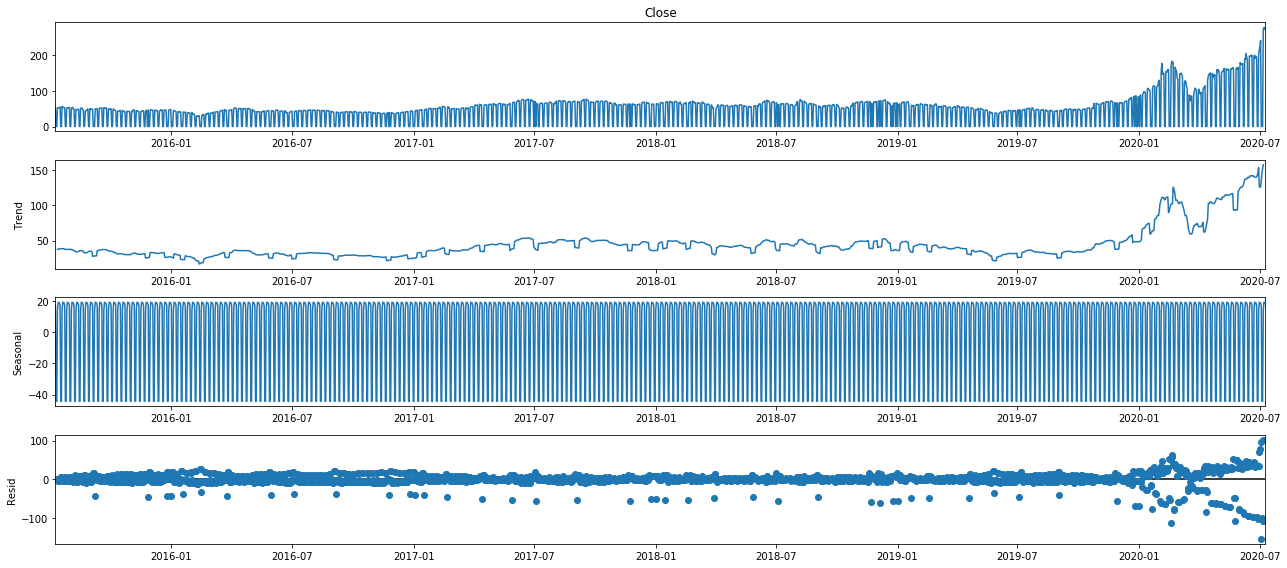

In [242]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = sm.tsa.seasonal_decompose(df['Close'], model='additive')
fig = decomposition.plot()
plt.show()

## Stationarity

Before we start modeling, we should mention such an important property of time series: stationarity.

If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called homoscedasticity)The covariance function does not depend on time; it should only depend on the distance between observations. You can see this visually on the images in the post by Sean Abu:

The red graph below is not stationary because the mean increases over time.
<img src="https://camo.githubusercontent.com/2f7be5667e1432b17075343c5e9576f9cd4f10ec/68747470733a2f2f686162726173746f726167652e6f72672f66696c65732f3230632f3964382f6136332f32306339643861363333656334333666393164636364346165646363363934302e706e67">

We were unlucky with the variance and see the varying spread of values over time
<img src="https://camo.githubusercontent.com/fc4a491c5740413340b148079d5adc32ca13fb39/68747470733a2f2f686162726173746f726167652e6f72672f66696c65732f6238382f6565632f6136372f62383865656361363736643634323434396361623133353237336664356139352e706e67">

Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice that the spread becomes closer as time increases. Hence, the covariance is not constant with time in the right chart.
<img src="https://camo.githubusercontent.com/63d660511c904eb0bc8f469a5ec124ce0a7ca0f9/68747470733a2f2f686162726173746f726167652e6f72672f66696c65732f3266362f3165652f6362322f32663631656563623230373134333532383430373438623832366533383638302e706e67">

So why is stationarity so important? 

Because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Furture predictions would be wrong if the original series were not stationary. Unfortunately, most of the time series that we see outside of textbooks are non-stationary, but we can (and should) change this.

<b>We can check stationarity using the following:

1. ACF and PACF plots:</b> If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.

<b>2. Plotting Rolling Statistics:</b> We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.

<b>3. Augmented Dickey-Fuller Test:</b> This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

## Augmented Dickey Fuller Test

Source: https://github.com/advaitsave/Introduction-to-Time-Series-forecasting-Python/blob/master/Time%20Series%20in%20Python.ipynb

- The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).
- Null hypothesis: The time series is not stationary
- Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

In [243]:
from statsmodels.tsa.stattools import adfuller

print("Results of Dickey-Fuller Test:")
dftest=adfuller(df.Close,autolag='AIC')
dfoutput=pd.Series(dftest[:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

#dftest
#dfoutput

#printing the critical values
for key,value in dftest[4].items():
    dfoutput['Critical value (%s)'%key]=value # assigns each critical key to it's critical value

print(dfoutput)

if(dfoutput['p-value']<0.05):
    print("The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary.")
else:
    print("The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.")

Results of Dickey-Fuller Test:
Test Statistic                    1.896416
p-value                           0.998522
#Lags Used                       22.000000
Number of Observations Used    1804.000000
Critical value (1%)              -3.433980
Critical value (5%)              -2.863143
Critical value (10%)             -2.567624
dtype: float64
The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.


In [244]:
#making the above code as a function to re-use it

def check_stationarity(df):
    from statsmodels.tsa.stattools import adfuller

    print("Results of Dickey-Fuller Test:")
    dftest=adfuller(df,autolag='AIC')
    dfoutput=pd.Series(dftest[:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    #dftest
    #dfoutput

    #printing the critical values
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key]=value # assigns each critical key to it's critical value

    print(dfoutput)

    if(dfoutput['p-value']<0.05):
        print("The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary.")
    else:
        print("The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.")

## ACF and PACF plot

- If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
- This data is non-stationary as a high number of previous observations are correlated with future values. In the ACF plot, we do not see a quick drop off in the correlation.
- Confidence intervals are drawn as a cone.
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

In [245]:
#writing a function to plot acf and pacf plot

def plot_acf_pacf(df):
    #importing libraries
    from matplotlib import pyplot
    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.graphics.tsaplots import plot_pacf
    
    pyplot.figure()
    pyplot.subplot(211)
    plot_acf(df,lags=30,ax=pyplot.gca())
    pyplot.subplot(212)
    plot_pacf(df,lags=30,ax=pyplot.gca())
    plt.show()

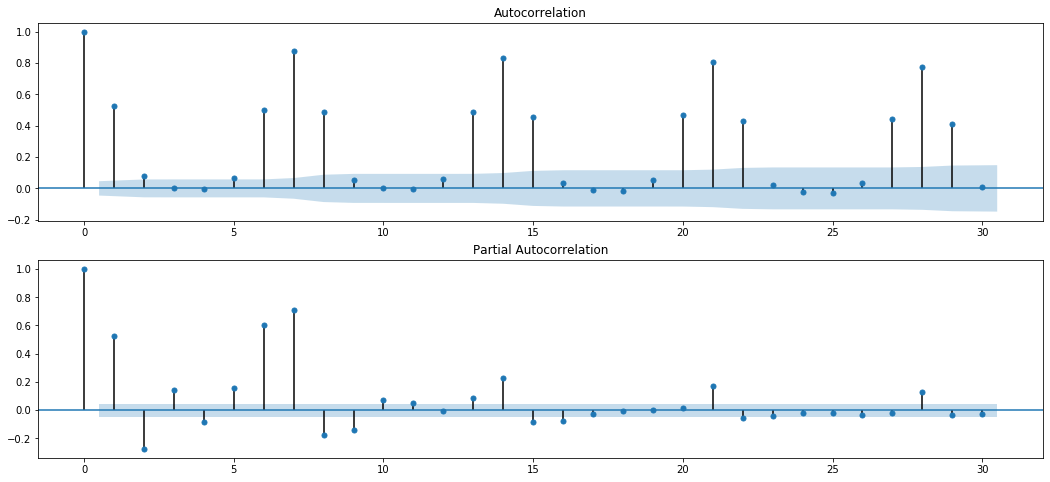

In [246]:
plot_acf_pacf(df)

## Making Time Series Stationary

There are 2 major reasons behind non-stationarity of a TS:

- Trend – varying mean over time. For eg, if the number of passengers were growing over time.

- Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

### Transformations
We can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, box cox,etc.

We will apply power transformer which tries to bring the distribution to a normal/gaussian shape.

In [247]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer()
df_transformed=df.copy()
df_transformed['Close']=pt.fit_transform(df.Close.values.reshape(-1,1))
df_transformed.head(5)

,Close
Date,
2015-07-10,0.478903
2015-07-11,-1.404007
2015-07-12,-1.404007
2015-07-13,0.489332
2015-07-14,0.501334


Results of Dickey-Fuller Test:
Test Statistic                   -1.106323
p-value                           0.712544
#Lags Used                       20.000000
Number of Observations Used    1806.000000
Critical value (1%)              -3.433976
Critical value (5%)              -2.863142
Critical value (10%)             -2.567623
dtype: float64
The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.


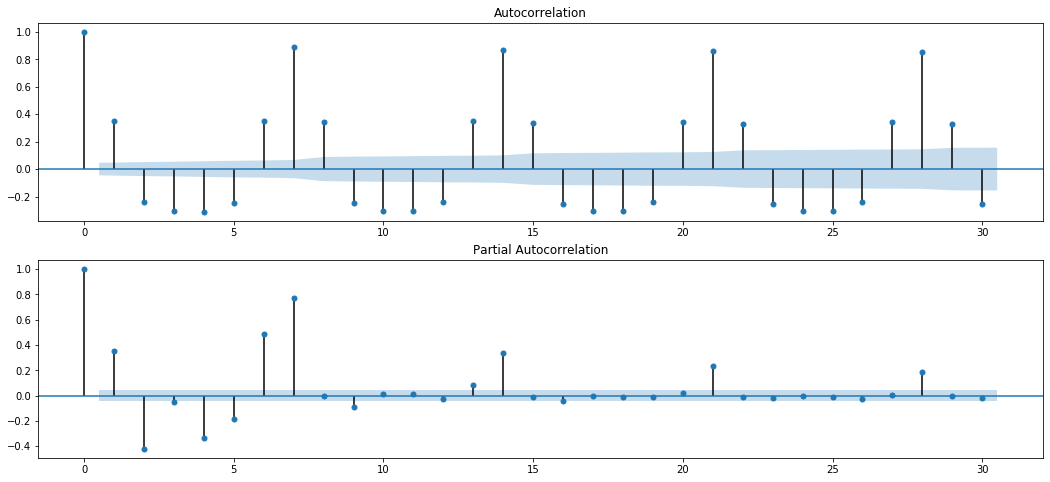

In [248]:
#checking stationarity of transformed series
check_stationarity(df_transformed)
plot_acf_pacf(df_transformed)

### Differencing
In this technique, we take the difference of the observation at a particular instant with that at the previous instant.

In [249]:
df_transformed_diff=df_transformed['Close']-df_transformed['Close'].shift()

In [250]:
"""
We will plot the line plot of original dataframe and the dataframe after box cox transformation and 
differencing to see the difference in plots
"""
px.line(df,x=df.index,y="Close",title="Dataset before Box Cox Transformation and Differencing")

In [251]:
px.line(df_transformed_diff,x=df_transformed_diff.index,y="Close",title="Dataset after Box Cox Transformation and Differencing")

Results of Dickey-Fuller Test:
Test Statistic                -1.813518e+01
p-value                        2.499680e-30
#Lags Used                     1.900000e+01
Number of Observations Used    1.806000e+03
Critical value (1%)           -3.433976e+00
Critical value (5%)           -2.863142e+00
Critical value (10%)          -2.567623e+00
dtype: float64
The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary.


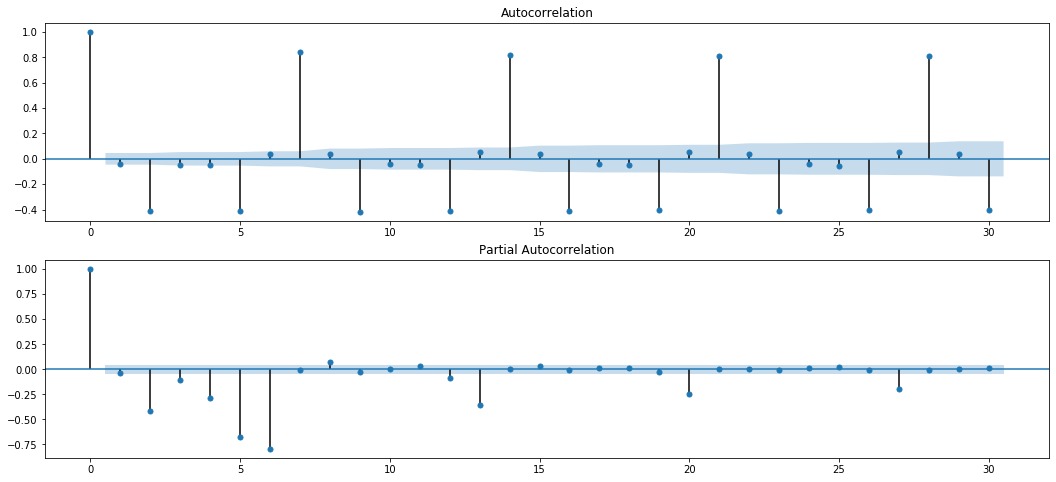

In [252]:
#checking stationarity of transformed series

df_transformed_diff.dropna(inplace=True)
check_stationarity(df_transformed_diff)
plot_acf_pacf(df_transformed_diff)

The above plot is the acf and pacf plot after applying first order differencing. Even with the first order of differencing, we observe that there is still slow residual decay in the ACF plots at a seasonal lag period of 7. This thus suggest a seasonal difference to be applied.

You can see that the upward significant line in the ACF plot is at the 7th lag then 17th lag and so ong. Since this is a daily dataset, this suggests a seasonal period of 7

In [253]:
df_transformed_diff2 = df_transformed.Close - df_transformed.Close.shift(7) #where s=seasonal periods

Results of Dickey-Fuller Test:
Test Statistic                -1.530946e+01
p-value                        4.205800e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.799000e+03
Critical value (1%)           -3.433990e+00
Critical value (5%)           -2.863148e+00
Critical value (10%)          -2.567626e+00
dtype: float64
The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary.


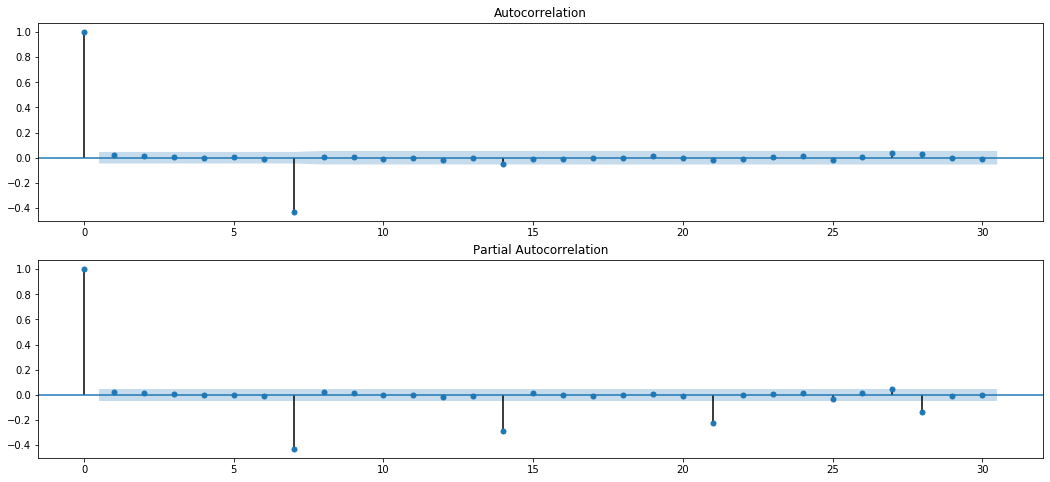

In [254]:
#checking stationarity of transformed series

df_transformed_diff2.dropna(inplace=True)
check_stationarity(df_transformed_diff2)
plot_acf_pacf(df_transformed_diff2)

Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. We can finally start modeling!

## ARIMA-family 

Source: https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb

We will explain this model by building up letter by letter. $SARIMA(p, d, q)(P, D, Q, s)$, Seasonal Autoregression Moving Average model:

$AR(p)$ - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as $p$. To determine the initial $p$, you need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.

$MA(q)$ - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as $q$. The initial value can be found on the ACF plot with the same logic as before.
Let's combine our first 4 letters:

$AR(p) + MA(q) = ARMA(p, q)$

What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

$I(d)$ - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences.
Adding this letter to the four gives us the $ARIMA$ model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

$S(s)$ - this is responsible for seasonality and equals the season period length of the series.For example, an S of 12 for monthly data suggests a yearly seasonal cycle.
With this, we have three parameters: $(P, D, Q)$

$P$ - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial $P$ should be 2.

$Q$ - similar logic using the ACF plot instead.

$D$ - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not. 

<b>To apply seasonal difference:</b> df_transformed = df_transformed.Count - df_transformed.Count.shift(s) where s=seasonal periods

Now that we know how to set the initial parameters, let's have a look at the final plot once again and set the parameters:

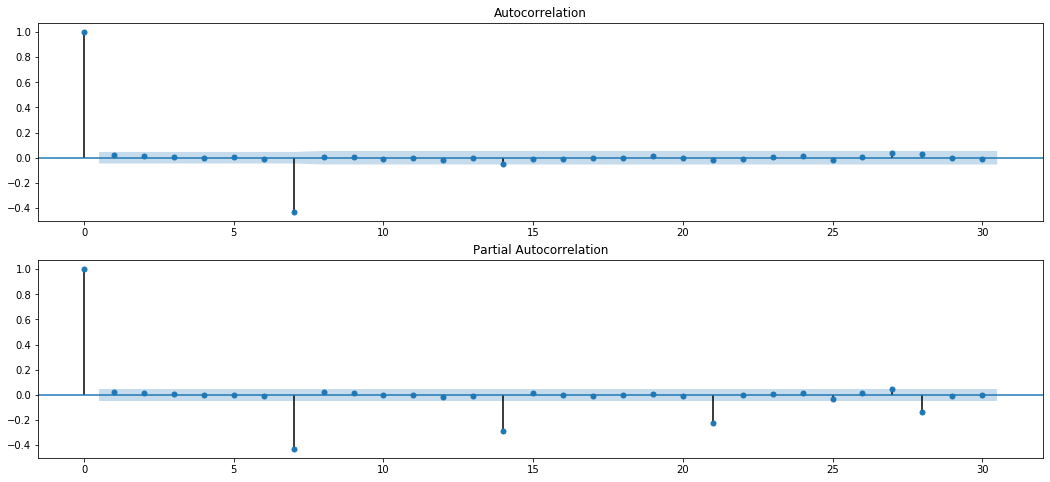

In [255]:
plot_acf_pacf(df_transformed_diff2)

- $p$ is most probably 6 since it is the last significant lag on the PACF, after which, most others are not significant.
- $d$ equals 1 because we had first differences
- $q$ should be somewhere around 6 as well as seen on the ACF

Seasonal Orders (if seasonality occurs):
- $P$ might be 2 as the period is 7 and the 7th lag is significant in the PACF plot and then 14th lag and so on
- $D$  equals 1 because we did perform seasonal differentiation
- $Q$ might be 1 as the period is 7 and the 7th lag is significant in the ACF plot but after that we do not have any significant lags

Let's test various models and see which one is better.

### Identify Seasonal periods

Source: https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima

Look at the ACF plot after transformation and differencing. 

Example:
<img src="https://storage.ning.com/topology/rest/1.0/file/get/2808377761?profile=RESIZE_1024x1024" width=800>

In the above diagram, we have a big value at lag 12 in the ACF plot which suggests our season is S = 12 and since this lag is positive it suggests P = 1 and Q = 0.

Another article: https://medium.com/@kfoofw/seasonal-lags-sarima-model-fa671a858729

<img src="https://miro.medium.com/max/700/1*mrg67q1undLb69-e1kP__Q.png" width=400>

The above plot is the acf and pacf plot after applying first order differencing. Even with the first order of differencing, we observe that there is still slow residual decay in the ACF plots at a seasonal lag period of 12. This thus suggest a seasonal difference to be applied.

<b>In our ACF plot, we do not see any spike in ACF plot.</b>

In [256]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

"""
using seasonal arima model with base values as the ones guessed above from the ACF and PACF plots
we will input P=1, Q=1 and D=1 as these values are required for seasonal ARIMA
later while doing gridsearch we will choose the optimal p,q,P,Q values
"""
base_model=sm.tsa.statespace.SARIMAX(df_transformed.Close, order=(6, 1, 6),seasonal_order=(2,1,1,7)).fit(disp=-1)
print(base_model.summary())

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                 1827
Model:             SARIMAX(6, 1, 6)x(2, 1, [1], 7)   Log Likelihood                -700.024
Date:                             Wed, 02 Sep 2020   AIC                           1432.047
Time:                                     19:19:54   BIC                           1520.144
Sample:                                 07-10-2015   HQIC                          1464.550
                                      - 07-09-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3831      0.758     -1.825      0.068      -2.869       0.103
ar.L2         -1.4676      

## Optimal values for SARIMA

In [259]:
# setting initial values and some bounds for them
from itertools import product 
ps = range(4, 8)
d=1 
qs = range(4, 8)
Ps = range(0, 4)
D=1 
Qs = range(0, 4)
s = 7

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

256

In [260]:
parameters_list[:2] # a list of different parameter combinations tuples

[(4, 4, 0, 0), (4, 4, 0, 1)]

In [261]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    from tqdm import tqdm_notebook
    s=7
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df_transformed.Close, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [262]:
%%time
d=1
D=1
result_table = optimizeSARIMA(parameters_list, d, D, s)

C:\Users\AJha\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\A

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\A

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. C

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\A


Wall time: 1h 44s


In [263]:
result_table.head(2)

,parameters,aic
0,"(4, 6, 2, 1)",1407.827706
1,"(4, 5, 0, 1)",1410.113896


Our base model had an AIC of 155 and now after finding the optimal values of p,q,P,Q we can see that the AIC is 149

In [271]:
p, q, P ,Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_transformed.Close, order=(p, 1, q),seasonal_order=(P,1,Q,7)).fit(disp=-1)
print(best_model.summary())

C:\Users\AJha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                 1827
Model:             SARIMAX(4, 1, 6)x(2, 1, [1], 7)   Log Likelihood                -689.914
Date:                             Wed, 02 Sep 2020   AIC                           1407.828
Time:                                     20:31:27   BIC                           1484.912
Sample:                                 07-10-2015   HQIC                          1436.268
                                      - 07-09-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9415      0.083    -23.487      0.000      -2.103      -1.779
ar.L2         -2.1424      

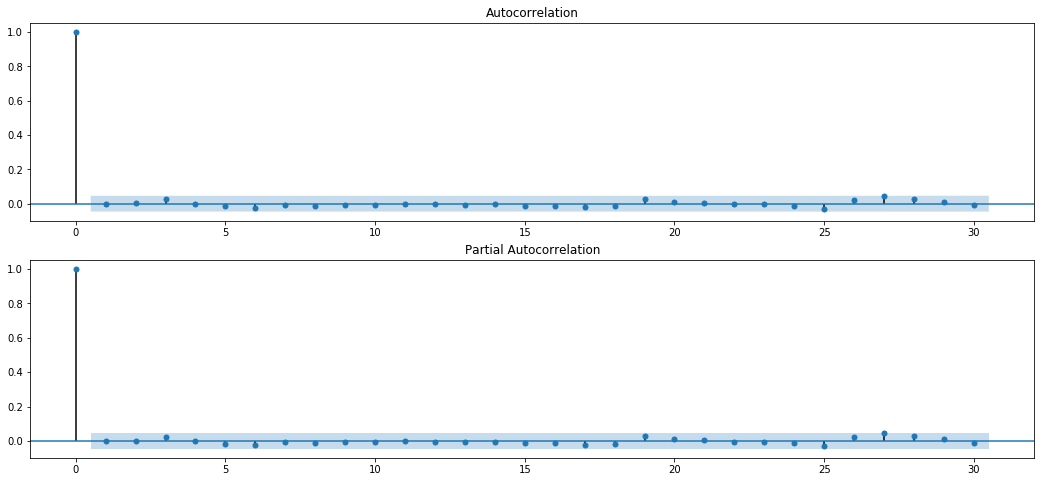

In [272]:
plot_acf_pacf(best_model.resid)

In [273]:
check_stationarity(best_model.resid)

Results of Dickey-Fuller Test:
Test Statistic                  -42.662559
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1826.000000
Critical value (1%)              -3.433936
Critical value (5%)              -2.863124
Critical value (10%)             -2.567613
dtype: float64
The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary.


It is clear that the residuals are stationary, and there are no major autocorrelations. Let's make predictions using our model.

In [274]:
best_model.resid.mean()

0.009611130497609402

A good time series forecasting shows 2 properties:

- Residuals in the model are uncorrelated – Plotting the residuals in the ACF plot will allow is to see if we have used all the info in our time series model.

- The residuals should have a mean close to 0 – if the residuals have a mean other than 0 then it is biased. If residuals have a mean other than 0, then add the mean to the forecasted value.

Our residuals are uncorrelated and the mean is also close to 0 so this time series is good enough to use for forecasting.

## Forecasting results

In [284]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    
    print(data)
    plt.figure(figsize=(15, 7))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);
    return forecast

              actual  arima_model
Date                             
2015-07-10  0.478903          NaN
2015-07-11 -1.404007          NaN
2015-07-12 -1.404007          NaN
2015-07-13  0.489332          NaN
2015-07-14  0.501334          NaN
...              ...          ...
2020-07-05 -1.404007    -1.170205
2020-07-06  2.587308     1.790635
2020-07-07  2.610040     2.177330
2020-07-08  2.580181     2.000208
2020-07-09  2.615509     1.950644

[1827 rows x 2 columns]


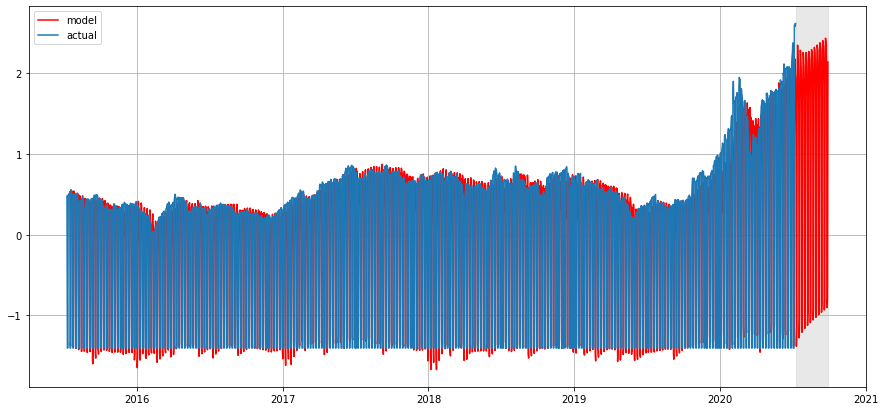

In [285]:
forecast=plotSARIMA(df_transformed, best_model, 80)

## Evaluating the performance

Before evaluating the performance, we need to transform our data back to the original scale using PowerTransformer()'s inverse_transform()

In [286]:
def plot_overall_graph(df_boxcox,forecast):
    import plotly.graph_objects as go
    import plotly
    
    forecast=pd.DataFrame(forecast)
    forecast.reset_index(inplace=True)
    forecast.columns=['Date','Predicted']
    
    #merging forecast and actual
    final_results=pd.merge(forecast,df_boxcox,left_on='Date',right_on='Date',how='left')
    
    final_results.columns=['Date','Transformed Predicted','Transformed Actual']
    
    #applying inverse_boxcox to get actual numbers
    final_results['Actual']=pt.inverse_transform(np.array(final_results['Transformed Actual']).reshape(-1, 1))
    final_results['Predicted']=pt.inverse_transform(np.array(final_results['Transformed Predicted']).reshape(-1, 1))

     
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=final_results['Date'], y=final_results['Actual'],name='Actual',line=dict(color='firebrick', width=4)))
    fig.add_trace(go.Scatter(x=final_results['Date'], y=final_results['Predicted'],name='Predicted',line=dict(color='royalblue', width=4)))

    # Edit the layout
    fig.update_layout(title='Stock Prediction for TESLA', xaxis_title='Date',yaxis_title='Closing Value')

    fig.show()
    
    return final_results

In [287]:
final_result=plot_overall_graph(df_transformed,forecast)

In [288]:
def _naive_forecasting(actual: np.ndarray, seasonality: int = 52):
    """ Naive forecasting method which just repeats previous samples """
    return actual[:-seasonality]

In [289]:
def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 52):
    from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mean_absolute_error(actual, predicted) /mean_absolute_error(actual[seasonality:], _naive_forecasting(actual, seasonality))

In [293]:
def evaluate_performance(final_results):
    from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
    eval_df=final_results.copy()
    eval_df.dropna(inplace=True)
    print("R2 score is:",r2_score(eval_df['Actual'],eval_df['Predicted']))
    print("MSE is:",mean_squared_error(eval_df['Actual'],eval_df['Predicted']))
    print("MAE is:",mean_absolute_error(eval_df['Actual'],eval_df['Predicted']))
    print("Mean Absolute Scaled Error(should be less than 1) is:",mase(eval_df['Actual'],eval_df['Predicted']))
    

In [294]:
evaluate_performance(final_result)

R2 score is: 0.8459424626929809
MSE is: 257.85112197043367
MAE is: 7.663176773646495
Mean Absolute Scaled Error(should be less than 1) is: 0.18120908112329862


The R2 value is 0.8 which is very close to 1. The Mean Absolute Scaled Error is much less than 1. 